# Time Series Forecasting 

A time series is data collected periodically, over time. Time series forecasting is the task of predicting future data points, given some historical data. It is commonly used in a variety of tasks from weather forecasting, retail and sales forecasting, stock market prediction, and in behavior prediction (such as predicting the flow of car traffic over a day). There is a lot of time series data out there, and recognizing patterns in that data is an active area of machine learning research!

<img src='notebook_ims/time_series_examples.png' width=80% />

In this notebook, we'll focus on one method for finding time-based patterns: using SageMaker's supervised learning model, [DeepAR](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html).


### DeepAR

DeepAR utilizes a recurrent neural network (RNN), which is designed to accept some sequence of data points as historical input and produce a predicted sequence of points. So, how does this model learn?

During training, you'll provide a training dataset (made of several time series) to a DeepAR estimator. The estimator looks at *all* the training time series and tries to identify similarities across them. It trains by randomly sampling **training examples** from the training time series. 
* Each training example consists of a pair of adjacent **context** and **prediction** windows of fixed, predefined lengths. 
    * The `context_length` parameter controls how far in the *past* the model can see.
    * The `prediction_length` parameter controls how far in the *future* predictions can be made.
    * You can find more details, in [this documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_how-it-works.html).

<img src='notebook_ims/context_prediction_windows.png' width=50% />

> Since DeepAR trains on several time series, it is well suited for data that exhibit **recurring patterns**.

In any forecasting task, you should choose the context window to provide enough, **relevant** information to a model so that it can produce accurate predictions. In general, data closest to the prediction time frame will contain the information that is most influential in defining that prediction. In many forecasting applications, like forecasting sales month-to-month, the context and prediction windows will be the same size, but sometimes it will be useful to have a larger context window to notice longer-term patterns in data.

### Energy Consumption Data

The data we'll be working with in this notebook is data about household electric power consumption, over the globe. The dataset is originally taken from [Kaggle](https://www.kaggle.com/uciml/electric-power-consumption-data-set), and represents power consumption collected over several years from 2006 to 2010. With such a large dataset, we can aim to predict over long periods of time, over days, weeks or months of time. Predicting energy consumption can be a useful task for a variety of reasons including determining seasonal prices for power consumption and efficiently delivering power to people, according to their predicted usage. 

**Interesting read**: An inversely-related project, recently done by Google and DeepMind, uses machine learning to predict the *generation* of power by wind turbines and efficiently deliver power to the grid. You can read about that research, [in this post](https://deepmind.com/blog/machine-learning-can-boost-value-wind-energy/).

### Machine Learning Workflow

This notebook approaches time series forecasting in a number of steps:
* Loading and exploring the data
* Creating training and test sets of time series
* Formatting data as JSON files and uploading to S3
* Instantiating and training a DeepAR estimator
* Deploying a model and creating a predictor
* Evaluating the predictor 

---

Let's start by loading in the usual resources.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Load and Explore the Data

We'll be loading in some data about global energy consumption, collected over a few years. The below cell downloads and unzips this data, giving you one text file of data, `household_power_consumption.txt`.

In [2]:
! wget https://s3.amazonaws.com/video.udacity-data.com/topher/2019/March/5c88a3f1_household-electric-power-consumption/household-electric-power-consumption.zip
! unzip household-electric-power-consumption

--2020-09-16 20:22:51--  https://s3.amazonaws.com/video.udacity-data.com/topher/2019/March/5c88a3f1_household-electric-power-consumption/household-electric-power-consumption.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.241.86
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.241.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20805339 (20M) [application/zip]
Saving to: ‘household-electric-power-consumption.zip’

household-electric- 100%[===================>]  19.84M  7.01MB/s    in 2.8s    

2020-09-16 20:22:54 (7.01 MB/s) - ‘household-electric-power-consumption.zip’ saved [20805339/20805339]

Archive:  household-electric-power-consumption.zip
  inflating: household_power_consumption.txt  


### Read in the `.txt` File

The next cell displays the first few lines in the text file, so we can see how it is formatted.

In [3]:
# display first ten lines of text data
n_lines = 10

with open('household_power_consumption.txt') as file:
    head = [next(file) for line in range(n_lines)]
    
display(head)

['Date;Time;Global_active_power;Global_reactive_power;Voltage;Global_intensity;Sub_metering_1;Sub_metering_2;Sub_metering_3\r\n',
 '16/12/2006;17:24:00;4.216;0.418;234.840;18.400;0.000;1.000;17.000\r\n',
 '16/12/2006;17:25:00;5.360;0.436;233.630;23.000;0.000;1.000;16.000\r\n',
 '16/12/2006;17:26:00;5.374;0.498;233.290;23.000;0.000;2.000;17.000\r\n',
 '16/12/2006;17:27:00;5.388;0.502;233.740;23.000;0.000;1.000;17.000\r\n',
 '16/12/2006;17:28:00;3.666;0.528;235.680;15.800;0.000;1.000;17.000\r\n',
 '16/12/2006;17:29:00;3.520;0.522;235.020;15.000;0.000;2.000;17.000\r\n',
 '16/12/2006;17:30:00;3.702;0.520;235.090;15.800;0.000;1.000;17.000\r\n',
 '16/12/2006;17:31:00;3.700;0.520;235.220;15.800;0.000;1.000;17.000\r\n',
 '16/12/2006;17:32:00;3.668;0.510;233.990;15.800;0.000;1.000;17.000\r\n']

## Pre-Process the Data

The 'household_power_consumption.txt' file has the following attributes:
   * Each data point has a date and time (hour:minute:second) of recording
   * The various data features are separated by semicolons (;)
   * Some values are 'nan' or '?', and we'll treat these both as `NaN` values

### Managing `NaN` values

This DataFrame does include some data points that have missing values. So far, we've mainly been dropping these values, but there are other ways to handle `NaN` values, as well. One technique is to just fill the missing column values with the **mean** value from that column; this way the added value is likely to be realistic.

I've provided some helper functions in `txt_preprocessing.py` that will help to load in the original text file as a DataFrame *and* fill in any `NaN` values, per column, with the mean feature value. This technique will be fine for long-term forecasting; if I wanted to do an hourly analysis and prediction, I'd consider dropping the `NaN` values or taking an average over a small, sliding window rather than an entire column of data.

**Below, I'm reading the file in as a DataFrame and filling `NaN` values with feature-level averages.**

In [4]:
import txt_preprocessing as pprocess

# create df from text file
initial_df = pprocess.create_df('household_power_consumption.txt', sep=';')

# fill NaN column values with *average* column value
df = pprocess.fill_nan_with_mean(initial_df)

# print some stats about the data
print('Data shape: ', df.shape)
df.head()

('Data shape: ', (2075259, 7))


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date-Time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


## Global Active Power 

In this example, we'll want to predict the global active power, which is the household minute-averaged active power (kilowatt), measured across the globe. So, below, I am getting just that column of data and displaying the resultant plot.

In [5]:
# Select Global active power data
power_df = df['Global_active_power'].copy()
print(power_df.shape)

(2075259,)


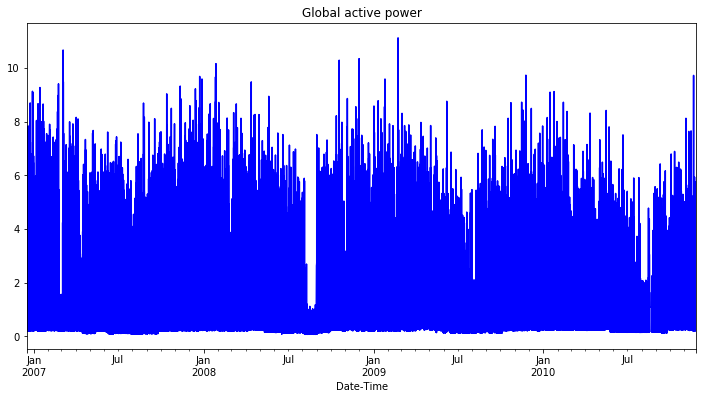

In [6]:
# display the data 
plt.figure(figsize=(12,6))
# all data points
power_df.plot(title='Global active power', color='blue') 
plt.show()

Since the data is recorded each minute, the above plot contains *a lot* of values. So, I'm also showing just a slice of data, below.

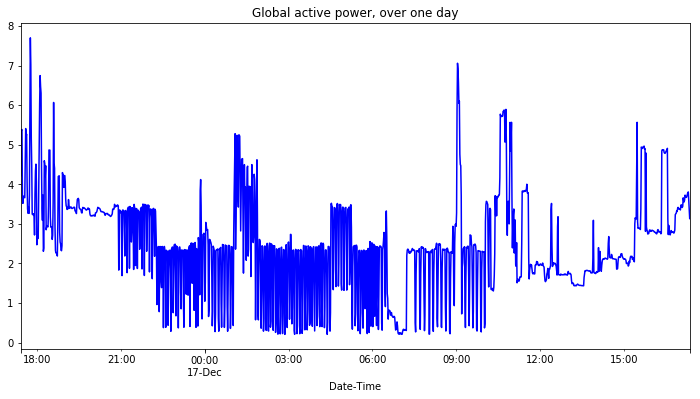

In [7]:
# can plot a slice of hourly data
end_mins = 1440 # 1440 mins = 1 day

plt.figure(figsize=(12,6))
power_df[0:end_mins].plot(title='Global active power, over one day', color='blue') 
plt.show()

### Hourly vs Daily

There is a lot of data, collected every minute, and so I could go one of two ways with my analysis:
1. Create many, short time series, say a week or so long, in which I record energy consumption every hour, and try to predict the energy consumption over the following hours or days.
2. Create fewer, long time series with data recorded daily that I could use to predict usage in the following weeks or months.

Both tasks are interesting! It depends on whether you want to predict time patterns over a day/week or over a longer time period, like a month. With the amount of data I have, I think it would be interesting to see longer, *recurring* trends that happen over several months or over a year. So, I will resample the 'Global active power' values, recording **daily** data points as averages over 24-hr periods.

> I can resample according to a specified frequency, by utilizing pandas [time series tools](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html), which allow me to sample at points like every hour ('H') or day ('D'), etc.



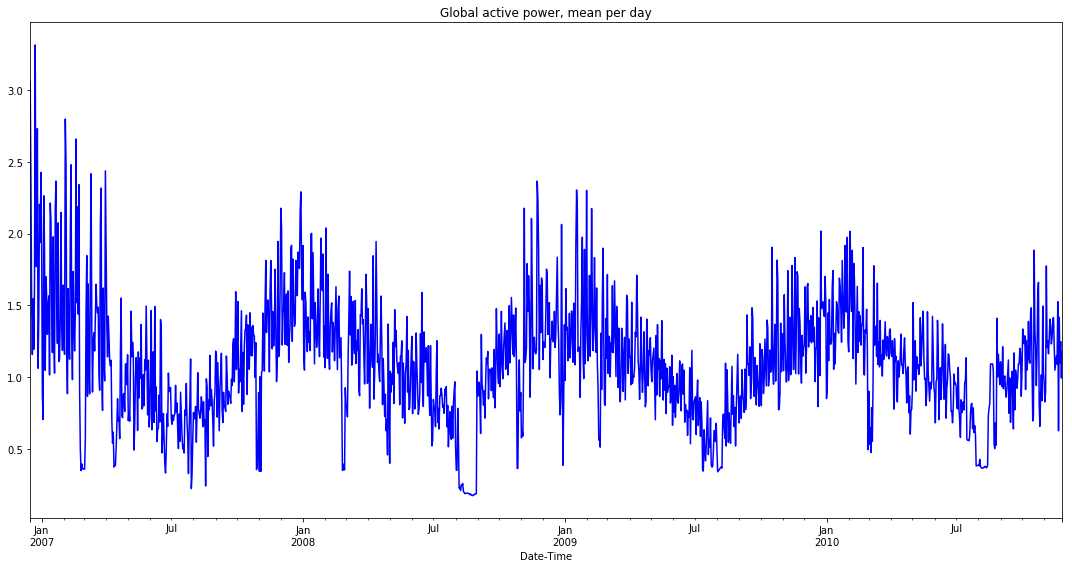

In [8]:
# resample over day (D)
freq = 'D'
# calculate the mean active power for a day
mean_power_df = power_df.resample(freq).mean()

# display the mean values
plt.figure(figsize=(15,8))
mean_power_df.plot(title='Global active power, mean per day', color='blue') 
plt.tight_layout()
plt.show()

In this plot, we can see that there are some interesting trends that occur over each year. It seems that there are spikes of energy consumption around the end/beginning of each year, which correspond with heat and light usage being higher in winter months. We also see a dip in usage around August, when global temperatures are typically higher.

The data is still not very smooth, but it shows noticeable trends, and so, makes for a good use case for machine learning models that may be able to recognize these patterns.

---
## Create Time Series 

My goal will be to take full years of data, from 2007-2009, and see if I can use it to accurately predict the average Global active power usage for the next several months in 2010!

Next, let's make one time series for each complete year of data. This is just a design decision, and I am deciding to use full years of data, starting in January of 2017 because there are not that many data points in 2006 and this split will make it easier to handle leap years; I could have also decided to construct time series starting at the first collected data point, just by changing `t_start` and `t_end` in the function below.

The function `make_time_series` will create pandas `Series` for each of the passed in list of years `['2007', '2008', '2009']`.
* All of the time series will start at the same time point `t_start` (or t0). 
    * When preparing data, it's important to use a consistent start point for each time series; DeepAR uses this time-point as a frame of reference, which enables it to learn recurrent patterns e.g. that weekdays behave differently from weekends or that Summer is different than Winter.
    * You can change the start and end indices to define any time series you create.
* We should account for leap years, like 2008, in the creation of time series.
* Generally, we create `Series` by getting the relevant global consumption data (from the DataFrame) and date indices.

```
# get global consumption data
data = mean_power_df[start_idx:end_idx]

# create time series for the year
index = pd.DatetimeIndex(start=t_start, end=t_end, freq='D')
time_series.append(pd.Series(data=data, index=index))
```

In [9]:
def make_time_series(mean_power_df, years, freq='D', start_idx=16):
    '''Creates as many time series as there are complete years. This code
       accounts for the leap year, 2008.
      :param mean_power_df: A dataframe of global power consumption, averaged by day.
          This dataframe should also be indexed by a datetime.
      :param years: A list of years to make time series out of, ex. ['2007', '2008'].
      :param freq: The frequency of data recording (D = daily)
      :param start_idx: The starting dataframe index of the first point in the first time series.
          The default, 16, points to '2017-01-01'. 
      :return: A list of pd.Series(), time series data.
      '''
    
    # store time series
    time_series = []
    
    # store leap year in this dataset
    leap = '2008'

    # create time series for each year in years
    for i in range(len(years)):

        year = years[i]
        if(year == leap):
            end_idx = start_idx+366
        else:
            end_idx = start_idx+365

        # create start and end datetimes
        t_start = year + '-01-01' # Jan 1st of each year = t_start
        t_end = year + '-12-31' # Dec 31st = t_end

        # get global consumption data
        data = mean_power_df[start_idx:end_idx]

        # create time series for the year
        index = pd.date_range(start=t_start, end=t_end, freq=freq)
        time_series.append(pd.Series(data=data, index=index))
        
        start_idx = end_idx
    
    # return list of time series
    return time_series
    

## Test the results

Below, let's construct one time series for each complete year of data, and display the results.

In [10]:
# test out the code above

# yearly time series for our three complete years
full_years = ['2007', '2008', '2009']
freq='D' # daily recordings

# make time series
time_series = make_time_series(mean_power_df, full_years, freq=freq)

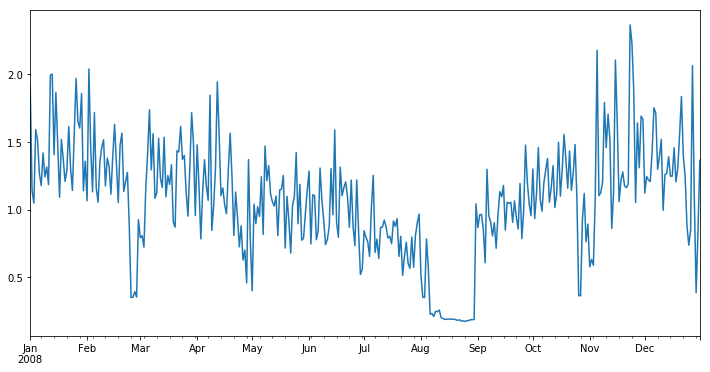

In [11]:
# display first time series
time_series_idx = 1

plt.figure(figsize=(12,6))
time_series[time_series_idx].plot()
plt.show()

In [12]:
time_series[0].head()

2007-01-01    1.909031
2007-01-02    0.881414
2007-01-03    0.704204
2007-01-04    2.263481
2007-01-05    1.884281
Freq: D, Name: Global_active_power, dtype: float64

---
# Splitting in Time

We'll evaluate our model on a test set of data. For machine learning tasks like classification, we typically create train/test data by randomly splitting examples into different sets. For forecasting it's important to do this train/test split in **time** rather than by individual data points. 
> In general, we can create training data by taking each of our *complete* time series and leaving off the last `prediction_length` data points to create *training* time series. 

### EXERCISE: Create training time series

Complete the `create_training_series` function, which should take in our list of complete time series data and return a list of truncated, training time series.

* In this example, we want to predict about a month's worth of data, and we'll set `prediction_length` to 30 (days).
* To create a training set of data, we'll leave out the last 30 points of *each* of the time series we just generated, so we'll use only the first part as training data. 
* The **test set contains the complete range** of each time series.


In [13]:
# create truncated, training time series
def create_training_series(complete_time_series, prediction_length):
    '''Given a complete list of time series data, create training time series.
       :param complete_time_series: A list of all complete time series.
       :param prediction_length: The number of points we want to predict.
       :return: A list of training time series.
       '''
    # your code here
        
    return [l[:-prediction_length] for l in complete_time_series]
    

In [14]:
# test your code!

# set prediction length
prediction_length = 30 # 30 days ~ a month

time_series_training = create_training_series(time_series, prediction_length)


### Training and Test Series

We can visualize what these series look like, by plotting the train/test series on the same axis. We should see that the test series contains all of our data in a year, and a training series contains all but the last `prediction_length` points.

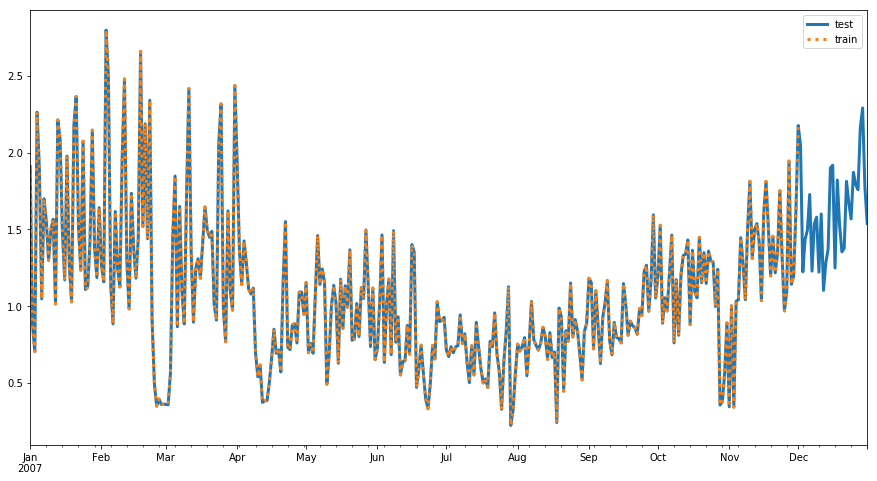

In [15]:
# display train/test time series
time_series_idx = 0

plt.figure(figsize=(15,8))
# test data is the whole time series
time_series[time_series_idx].plot(label='test', lw=3)
# train data is all but the last prediction pts
time_series_training[time_series_idx].plot(label='train', ls=':', lw=3)

plt.legend()
plt.show()

## Convert to JSON 

According to the [DeepAR documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html), DeepAR expects to see input training data in a JSON format, with the following fields:

* **start**: A string that defines the starting date of the time series, with the format 'YYYY-MM-DD HH:MM:SS'.
* **target**: An array of numerical values that represent the time series.
* **cat** (optional): A numerical array of categorical features that can be used to encode the groups that the record belongs to. This is useful for finding models per class of item, such as in retail sales, where you might have {'shoes', 'jackets', 'pants'} encoded as categories {0, 1, 2}.

The input data should be formatted with one time series per line in a JSON file. Each line looks a bit like a dictionary, for example:
```
{"start":'2007-01-01 00:00:00', "target": [2.54, 6.3, ...], "cat": [1]}
{"start": "2012-01-30 00:00:00", "target": [1.0, -5.0, ...], "cat": [0]} 
...
```
In the above example, each time series has one, associated categorical feature and one time series feature.

### EXERCISE: Formatting Energy Consumption Data

For our data:
* The starting date, "start," will be the index of the first row in a time series, Jan. 1st of that year.
* The "target" will be all of the energy consumption values that our time series holds.
* We will not use the optional "cat" field.

Complete the following utility function, which should convert `pandas.Series` objects into the appropriate JSON strings that DeepAR can consume.

In [16]:
def series_to_json_obj(ts):
    '''Returns a dictionary of values in DeepAR, JSON format.
       :param ts: A single time series.
       :return: A dictionary of values with "start" and "target" keys.
       '''
    # your code here
    jsn = {'start': str(ts.index[0]), 'target': list(ts)}
    return jsn


In [17]:
# test out the code
ts = time_series[0]

json_obj = series_to_json_obj(ts)

print(json_obj)

{'start': '2007-01-01 00:00:00', 'target': [1.9090305555555664, 0.8814138888888893, 0.7042041666666671, 2.263480555555549, 1.8842805555555506, 1.047484722222222, 1.6997361111111127, 1.5564999999999982, 1.2979541666666659, 1.496388888888886, 1.5661069444444446, 1.0147888888888905, 2.2130652777777766, 2.0895191771086794, 1.4921374999999986, 1.1711138888888888, 1.9775611111111107, 1.2649041666666674, 1.0280833333333352, 2.176202777777775, 2.3661541666666652, 1.5142319444444445, 1.2344722222222224, 2.07489861111111, 1.1085722222222205, 1.1235916666666654, 1.419494444444445, 2.146733065997562, 1.3768500000000001, 1.1859708333333323, 1.6414944444444453, 1.2671944444444443, 1.1581499999999982, 2.798418055555553, 2.4971805555555573, 1.1425555555555553, 0.8843611111111115, 1.6166791666666673, 1.2509819444444445, 1.1251375000000008, 1.9648111111111108, 2.4800194444444434, 1.3038958333333335, 0.9823236111111113, 1.7351888888888864, 1.3787124999999985, 1.1823111111111093, 1.4423000000000017, 2.659

### Saving Data, Locally

The next helper function will write one series to a single JSON line, using the new line character '\n'. The data is also encoded and written to a filename that we specify.

In [18]:
# import json for formatting data
import json
import os # and os for saving

def write_json_dataset(time_series, filename): 
    with open(filename, 'wb') as f:
        # for each of our times series, there is one JSON line
        for ts in time_series:
            json_line = json.dumps(series_to_json_obj(ts)) + '\n'
            json_line = json_line.encode('utf-8')
            f.write(json_line)
    print(filename + ' saved.')

In [19]:
# save this data to a local directory
data_dir = 'json_energy_data'

# make data dir, if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [20]:
# directories to save train/test data
train_key = os.path.join(data_dir, 'train.json')
test_key = os.path.join(data_dir, 'test.json')

# write train/test JSON files
write_json_dataset(time_series_training, train_key)        
write_json_dataset(time_series, test_key)

json_energy_data/train.json saved.
json_energy_data/test.json saved.


---
## Uploading Data to S3

Next, to make this data accessible to an estimator, I'll upload it to S3.

### Sagemaker resources

Let's start by specifying:
* The sagemaker role and session for training a model.
* A default S3 bucket where we can save our training, test, and model data.

In [21]:
import boto3
import sagemaker
from sagemaker import get_execution_role

No handlers could be found for logger "sagemaker"


In [22]:
# session, role, bucket
sagemaker_session = sagemaker.Session()
role = get_execution_role()

bucket = sagemaker_session.default_bucket()


### EXERCISE: Upoad *both* training and test JSON files to S3

Specify *unique* train and test prefixes that define the location of that data in S3.
* Upload training data to a location in S3, and save that location to `train_path`
* Upload test data to a location in S3, and save that location to `test_path`

In [26]:
# suggested that you set prefixes for directories in S3
prefix='deepar-energy-consumption'

train_prefix = '{}/train'.format(prefix)
test_prefix = '{}/test'.format(prefix)
# upload data to S3, and save unique locations
train_path = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path = sagemaker_session.upload_data(test_key, bucket=bucket, key_prefix=test_prefix)

In [27]:
# check locations
print('Training data is stored in: '+ train_path)
print('Test data is stored in: '+ test_path)

Training data is stored in: s3://sagemaker-eu-west-1-100264508876/deepar-energy-consumption/train/train.json
Test data is stored in: s3://sagemaker-eu-west-1-100264508876/deepar-energy-consumption/test/test.json


---
# Training a DeepAR Estimator

Some estimators have specific, SageMaker constructors, but not all. Instead you can create a base `Estimator` and pass in the specific image (or container) that holds a specific model.

Next, we configure the container image to be used for the region that we are running in.

In [28]:
from sagemaker.amazon.amazon_estimator import get_image_uri

image_name = get_image_uri(boto3.Session().region_name, # get the region
                           'forecasting-deepar') # specify image


### EXERCISE: Instantiate an Estimator 

You can now define the estimator that will launch the training job. A generic Estimator will be defined by the usual constructor arguments and an `image_name`. 
> You can take a look at the [estimator source code](https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/estimator.py#L595) to view specifics.


In [34]:
from sagemaker.estimator import Estimator

output_path = 's3://{}/{}/output'.format(bucket, prefix)
# instantiate a DeepAR estimator
estimator = Estimator(role=role,
                      sagemaker_session=sagemaker_session,
                      train_instance_count=1,
                      train_instance_type='ml.c4.xlarge',
                      output_path=output_path,
                      image_name=image_name)

## Setting Hyperparameters

Next, we need to define some DeepAR hyperparameters that define the model size and training behavior. Values for the epochs, frequency, prediction length, and context length are required.

* **epochs**: The maximum number of times to pass over the data when training.
* **time_freq**: The granularity of the time series in the dataset ('D' for daily).
* **prediction_length**: A string; the number of time steps (based off the unit of frequency) that the model is trained to predict. 
* **context_length**: The number of time points that the model gets to see *before* making a prediction. 

### Context Length

Typically, it is recommended that you start with a `context_length`=`prediction_length`. This is because a DeepAR model also receives "lagged" inputs from the target time series, which allow the model to capture long-term dependencies. For example, a daily time series can have yearly seasonality and DeepAR automatically includes a lag of one year. So, the context length can be shorter than a year, and the model will still be able to capture this seasonality. 

The lag values that the model picks depend on the frequency of the time series. For example, lag values for daily frequency are the previous week, 2 weeks, 3 weeks, 4 weeks, and year. You can read more about this in the [DeepAR "how it works" documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_how-it-works.html).

### Optional Hyperparameters

You can also configure optional hyperparameters to further tune your model. These include parameters like the number of layers in our RNN model, the number of cells per layer, the likelihood function, and the training options, such as batch size and learning rate. 

For an exhaustive list of all the different DeepAR hyperparameters you can refer to the DeepAR [hyperparameter documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html).

In [35]:
freq='D'
context_length=30 # same as prediction_length

hyperparameters = {
    "epochs": "50",
    "time_freq": freq,
    "prediction_length": str(prediction_length),
    "context_length": str(context_length),
    "num_cells": "50",
    "num_layers": "2",
    "mini_batch_size": "128",
    "learning_rate": "0.001",
    "early_stopping_patience": "10"
}

In [36]:
# set the hyperparams
estimator.set_hyperparameters(**hyperparameters)

## Training Job

Now, we are ready to launch the training job! SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

If you provide the `test` data channel, as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test data set. This is done by predicting the last `prediction_length` points of each time series in the test set and comparing this to the *actual* value of the time series. The computed error metrics will be included as part of the log output.

The next cell may take a few minutes to complete, depending on data size, model complexity, and training options.

In [37]:
%%time
# train and test channels
data_channels = {
    "train": train_path,
    "test": test_path
}

# fit the estimator
estimator.fit(inputs=data_channels)

2020-09-16 20:31:35 Starting - Starting the training job...
2020-09-16 20:31:37 Starting - Launching requested ML instances......
2020-09-16 20:32:42 Starting - Preparing the instances for training.........
2020-09-16 20:34:29 Downloading - Downloading input data
2020-09-16 20:34:29 Training - Downloading the training image...
2020-09-16 20:34:48 Training - Training image download completed. Training in progress.Arguments: train
[09/16/2020 20:34:51 INFO 140295146850112] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u

## Deploy and Create a Predictor

Now that we have trained a model, we can use it to perform predictions by deploying it to a predictor endpoint.

Remember to **delete the endpoint** at the end of this notebook. A cell at the very bottom of this notebook will be provided, but it is always good to keep, front-of-mind.

In [ ]:
%%time

# create a predictor
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    content_type="application/json" # specify that it will accept/produce JSON
)

----------!CPU times: user 283 ms, sys: 12.8 ms, total: 296 ms
Wall time: 7min 33s


---
# Generating Predictions

According to the [inference format](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar-in-formats.html) for DeepAR, the `predictor` expects to see input data in a JSON format, with the following keys:
* **instances**: A list of JSON-formatted time series that should be forecast by the model.
* **configuration** (optional): A dictionary of configuration information for the type of response desired by the request.

Within configuration the following keys can be configured:
* **num_samples**: An integer specifying the number of samples that the model generates when making a probabilistic prediction.
* **output_types**: A list specifying the type of response. We'll ask for **quantiles**, which look at the list of num_samples generated by the model, and generate [quantile estimates](https://en.wikipedia.org/wiki/Quantile) for each time point based on these values.
* **quantiles**: A list that specified which quantiles estimates are generated and returned in the response.


Below is an example of what a JSON query to a DeepAR model endpoint might look like.

```
{
 "instances": [
  { "start": "2009-11-01 00:00:00", "target": [4.0, 10.0, 50.0, 100.0, 113.0] },
  { "start": "1999-01-30", "target": [2.0, 1.0] }
 ],
 "configuration": {
  "num_samples": 50,
  "output_types": ["quantiles"],
  "quantiles": ["0.5", "0.9"]
 }
}
```


## JSON Prediction Request

The code below accepts a **list** of time series as input and some configuration parameters. It then formats that series into a JSON instance and converts the input into an appropriately formatted JSON_input.

In [39]:
def json_predictor_input(input_ts, num_samples=50, quantiles=['0.1', '0.5', '0.9']):
    '''Accepts a list of input time series and produces a formatted input.
       :input_ts: An list of input time series.
       :num_samples: Number of samples to calculate metrics with.
       :quantiles: A list of quantiles to return in the predicted output.
       :return: The JSON-formatted input.
       '''
    # request data is made of JSON objects (instances)
    # and an output configuration that details the type of data/quantiles we want
    
    instances = []
    for k in range(len(input_ts)):
        # get JSON objects for input time series
        instances.append(series_to_json_obj(input_ts[k]))

    # specify the output quantiles and samples
    configuration = {"num_samples": num_samples, 
                     "output_types": ["quantiles"], 
                     "quantiles": quantiles}

    request_data = {"instances": instances, 
                    "configuration": configuration}

    json_request = json.dumps(request_data).encode('utf-8')
    
    return json_request

### Get a Prediction

We can then use this function to get a prediction for a formatted time series!

In the next cell, I'm getting an input time series and known target, and passing the formatted input into the predictor endpoint to get a resultant prediction.

In [40]:
# get all input and target (test) time series
input_ts = time_series_training
target_ts = time_series

# get formatted input time series
json_input_ts = json_predictor_input(input_ts)

# get the prediction from the predictor
json_prediction = predictor.predict(json_input_ts)

print(json_prediction)

{"predictions":[{"quantiles":{"0.1":[1.0181889534,1.0775762796,1.3786475658,1.1469641924,0.9773305058,1.1721650362,1.425494194,1.3885740042,1.0079169273,1.2945048809,1.0559229851,1.0471650362,1.1102571487,1.0471980572,1.1870758533,0.882768929,1.0468715429,0.9609694481,1.0295710564,1.0005164146,1.0025795698,0.9258389473,0.8689789772,0.9195222855,0.8356977701,0.682626307,0.9428085089,0.8492372036,0.8780366182,0.657972455],"0.9":[1.9133865833,1.6029471159,1.901219368,1.560136199,1.5271980762,1.9539819956,1.9546871185,1.9153608084,1.6497087479,1.814368844,1.6535240412,1.430109024,1.7375962734,1.8188692331,1.9341447353,1.5156366825,1.6752064228,1.6023343801,1.5362144709,1.7661960125,2.0583791733,1.6540236473,1.3869595528,1.5846871138,1.4296182394,1.1981754303,1.4821451902,1.7545609474,1.8298617601,1.3203390837],"0.5":[1.4594604969,1.3066012859,1.6319520473,1.3696968555,1.2418162823,1.6190803051,1.6818480492,1.6468966007,1.2254817486,1.4751253128,1.209574461,1.2474739552,1.4208292961,1.50908

## Decoding Predictions

The predictor returns JSON-formatted prediction, and so we need to extract the predictions and quantile data that we want for visualizing the result. The function below, reads in a JSON-formatted prediction and produces a list of predictions in each quantile.

In [41]:
# helper function to decode JSON prediction
def decode_prediction(prediction, encoding='utf-8'):
    '''Accepts a JSON prediction and returns a list of prediction data.
    '''
    prediction_data = json.loads(prediction.decode(encoding))
    prediction_list = []
    for k in range(len(prediction_data['predictions'])):
        prediction_list.append(pd.DataFrame(data=prediction_data['predictions'][k]['quantiles']))
    return prediction_list


In [42]:
# get quantiles/predictions
prediction_list = decode_prediction(json_prediction)

# should get a list of 30 predictions 
# with corresponding quantile values
print(prediction_list[0])

         0.1       0.5       0.9
0   1.018189  1.459460  1.913387
1   1.077576  1.306601  1.602947
2   1.378648  1.631952  1.901219
3   1.146964  1.369697  1.560136
4   0.977331  1.241816  1.527198
5   1.172165  1.619080  1.953982
6   1.425494  1.681848  1.954687
7   1.388574  1.646897  1.915361
8   1.007917  1.225482  1.649709
9   1.294505  1.475125  1.814369
10  1.055923  1.209574  1.653524
11  1.047165  1.247474  1.430109
12  1.110257  1.420829  1.737596
13  1.047198  1.509089  1.818869
14  1.187076  1.532403  1.934145
15  0.882769  1.190578  1.515637
16  1.046872  1.382347  1.675206
17  0.960969  1.281531  1.602334
18  1.029571  1.267627  1.536214
19  1.000516  1.373059  1.766196
20  1.002580  1.498289  2.058379
21  0.925839  1.237327  1.654024
22  0.868979  1.053336  1.386960
23  0.919522  1.251925  1.584687
24  0.835698  1.169960  1.429618
25  0.682626  0.995479  1.198175
26  0.942809  1.215333  1.482145
27  0.849237  1.352150  1.754561
28  0.878037  1.245107  1.829862
29  0.6579

## Display the Results!

The quantile data will give us all we need to see the results of our prediction.
* Quantiles 0.1 and 0.9 represent higher and lower bounds for the predicted values.
* Quantile 0.5 represents the median of all sample predictions.


In [43]:
# display the prediction median against the actual data
def display_quantiles(prediction_list, target_ts=None):
    # show predictions for all input ts
    for k in range(len(prediction_list)):
        plt.figure(figsize=(12,6))
        # get the target month of data
        if target_ts is not None:
            target = target_ts[k][-prediction_length:]
            plt.plot(range(len(target)), target, label='target')
        # get the quantile values at 10 and 90%
        p10 = prediction_list[k]['0.1']
        p90 = prediction_list[k]['0.9']
        # fill the 80% confidence interval
        plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
        # plot the median prediction line
        prediction_list[k]['0.5'].plot(label='prediction median')
        plt.legend()
        plt.show()

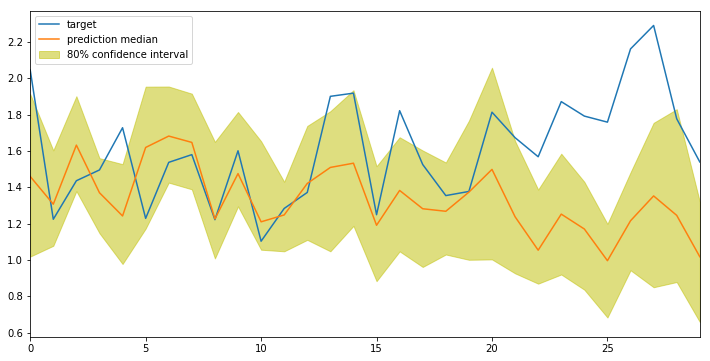

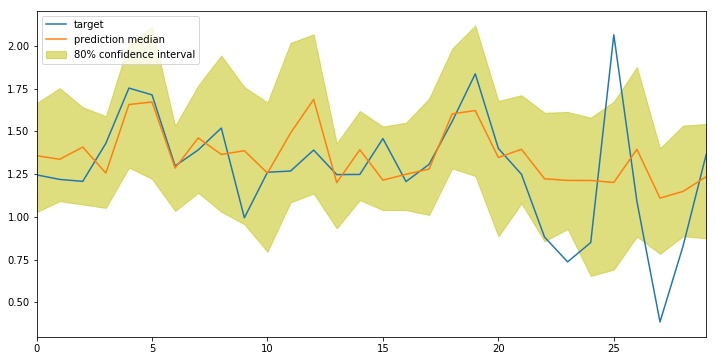

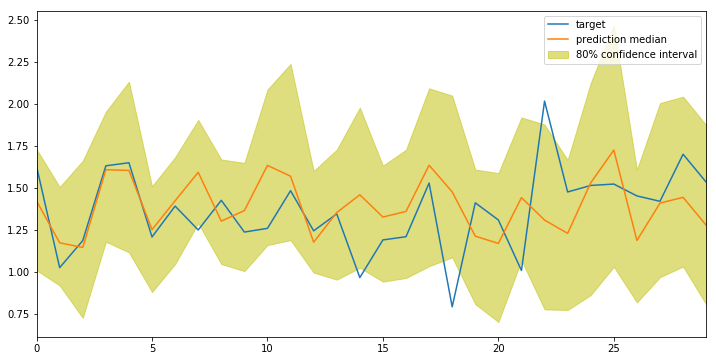

In [44]:
# display predictions
display_quantiles(prediction_list, target_ts)

## Predicting the Future

Recall that we did not give our model any data about 2010, but let's see if it can predict the energy consumption given **no target**, only a known start date!

### EXERCISE: Format a request for a "future" prediction

Create a formatted input to send to the deployed `predictor` passing in my usual parameters for "configuration". The "instances" will, in this case, just be one instance, defined by the following:
* **start**: The start time will be time stamp that you specify. To predict the first 30 days of 2010, start on Jan. 1st, '2010-01-01'.
* **target**: The target will be an empty list because this year has no, complete associated time series; we specifically withheld that information from our model, for testing purposes.
```
{"start": start_time, "target": []} # empty target
```

In [45]:
# Starting my prediction at the beginning of 2010
start_date = '2010-01-01'
timestamp = '00:00:00'

# formatting start_date
start_time = start_date +' '+ timestamp

# format the request_data
# with "instances" and "configuration"
request_data = {"instances": [{"start": start_time, "target": []}],
                "configuration": {"num_samples": 50,
                                  "output_types": ["quantiles"],
                                  "quantiles": ['0.1', '0.5', '0.9']}
                }


# create JSON input
json_input = json.dumps(request_data).encode('utf-8')

print('Requesting prediction for '+start_time)

Requesting prediction for 2010-01-01 00:00:00


Then get and decode the prediction response, as usual.

In [46]:
# get prediction response
json_prediction = predictor.predict(json_input)

prediction_2010 = decode_prediction(json_prediction)


Finally, I'll compare the predictions to a known target sequence. This target will come from a time series for the 2010 data, which I'm creating below.

In [47]:
# create 2010 time series
ts_2010 = []
# get global consumption data
# index 1112 is where the 2011 data starts
data_2010 = mean_power_df.values[1112:]

index = pd.DatetimeIndex(start=start_date, periods=len(data_2010), freq='D')
ts_2010.append(pd.Series(data=data_2010, index=index))


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p27/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


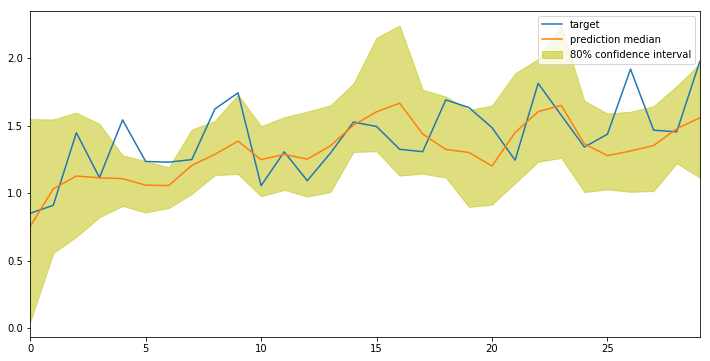

In [48]:
# range of actual data to compare
start_idx=0 # days since Jan 1st 2010
end_idx=start_idx+prediction_length

# get target data
target_2010_ts = [ts_2010[0][start_idx:end_idx]]

# display predictions
display_quantiles(prediction_2010, target_2010_ts)

## Delete the Endpoint

Try your code out on different time series. You may want to tweak your DeepAR hyperparameters and see if you can improve the performance of this predictor.

When you're done with evaluating the predictor (any predictor), make sure to delete the endpoint.

In [49]:
## TODO: delete the endpoint
predictor.delete_endpoint()

## Conclusion

Now you've seen one complex but far-reaching method for time series forecasting. You should have the skills you need to apply the DeepAR model to data that interests you!